In [2]:
!echo $HOSTNAME

n-62-20-9


In [3]:
import os
import numpy as np
import pickle
import copy

In [4]:
import matplotlib.pyplot as plt

In [5]:
from cil.io import NikonDataReader, RAWFileWriter, TIFFStackReader, TIFFWriter
from cil.utilities.jupyter import islicer
from cil.utilities.display import show_geometry, show2D
from cil.recon import FDK
from cil.plugins.tigre import FBP, ProjectionOperator
from cil.processors import TransmissionAbsorptionConverter, Slicer, CentreOfRotationCorrector
from cil.optimisation.algorithms import CGLS, SIRT
from cil.framework import ImageData, ImageGeometry, AcquisitionData, AcquisitionGeometry

In [42]:
base_dir = os.path.abspath('/dtu/3d-imaging-center/projects/2022_DANFIX_Vindelev/raw_data_3DIM/')
# path = os.path.join(base_dir,'VKH8206-X20 [2022-02-08 10.27.26]/VKH8206-X20_recon.xtekct')
# path = os.path.join(base_dir,'VKH8206-X20 [2022-02-08 10.27.26]/VKH8206-X20.xtekct')
# path = os.path.join(base_dir,'VKH8206-X16 [2022-02-07 10.28.35]/VKH8206-X16_recon.xtekct')
# path = os.path.join(base_dir,'VKH8206-X10 [2022-02-10 10.55.25]/VKH8206-X10.xtekct')
# path = os.path.join(base_dir,'VKH8206-X10 [2022-02-10 10.55.25]/VKH8206-X10_recon.xtekct')
path = os.path.join(base_dir,'VKH8206-X12-X22 [2022-02-08 13.26.56]/VKH8206-X12-X22.xtekct')

reader = NikonDataReader(file_name=path)
data = reader.read()

In [7]:
ag = data.geometry
ig = ag.get_ImageGeometry()
print(ag)
print(ig)
# show_geometry(ag, ig)

3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -255.77484131,    0.        ]
	Rotation axis position: [0.27062218, 0.        , 0.        ]
	Rotation axis direction: [0.0021087 , 0.        , 0.99999778]
	Detector position: [ -0.        , 855.97315869,   0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1000 1000]
	Pixel size: [0.4 0.4]
	Pixel origin: top-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 1571
	Angles 0-20 in degrees:
[180.     , 179.77084, 179.54169, 179.31255, 179.08339, 178.85423,
 178.62508, 178.39592, 178.16678, 177.93762, 177.70847, 177.47931,
 177.25015, 177.02101, 176.79185, 176.5627 , 176.33354, 176.10439,
 175.87524, 175.64609]
Distances in units: units distance
Number of channels: 1
channel_spacing: 1.0
voxel_num : x1000,y1000,z1000
voxel_size : x0.09202619345700429,y0.09202619345700429,z0.09202619345700429

In [66]:
# data_centre = data.get_slice(vertical='centre',force=True)
# type(data_centre)

In [8]:
offset = 0.27062218
# offset = 0
ag2 = AcquisitionGeometry.create_Cone3D(
    source_position=[0,-255.77484131,0], detector_position=[0,855.97315869,0],
    detector_direction_x=[1,0,0], detector_direction_y=[0,0,1],
    rotation_axis_position=[offset,0,0], rotation_axis_direction=[0,0,1]
    )\
    .set_panel(num_pixels=[ag.pixel_num_h,ag.pixel_num_v],pixel_size=[ag.pixel_size_h,ag.pixel_size_v])\
    .set_angles(angles=ag.angles)

data2 = AcquisitionData(array=data.as_array(),deep_copy=True,geometry=ag2)
print(data2.geometry)
print(data2.geometry.get_ImageGeometry())

3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -255.77484131,    0.        ]
	Rotation axis position: [0.27062218, 0.        , 0.        ]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [  0.        , 855.97315869,   0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1000 1000]
	Pixel size: [0.4 0.4]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 1571
	Angles 0-20 in degrees:
[180.     , 179.77084, 179.54169, 179.31255, 179.08339, 178.85423,
 178.62508, 178.39592, 178.16678, 177.93762, 177.70847, 177.47931,
 177.25015, 177.02101, 176.79185, 176.5627 , 176.33354, 176.10439,
 175.87524, 175.64609]
Distances in units: units distance
Number of channels: 1
channel_spacing: 1.0
voxel_num : x1000,y1000,z1000
voxel_size : x0.09202619345751015,y0.09202619345751015,z0.09202619345751015
center : x0,y0,z0



In [9]:
data_centre = data2.get_slice(vertical='centre')

FDK recon

Input Data:
	angle: 1571
	horizontal: 1000

Reconstruction Volume:
	horizontal_y: 1000
	horizontal_x: 1000

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



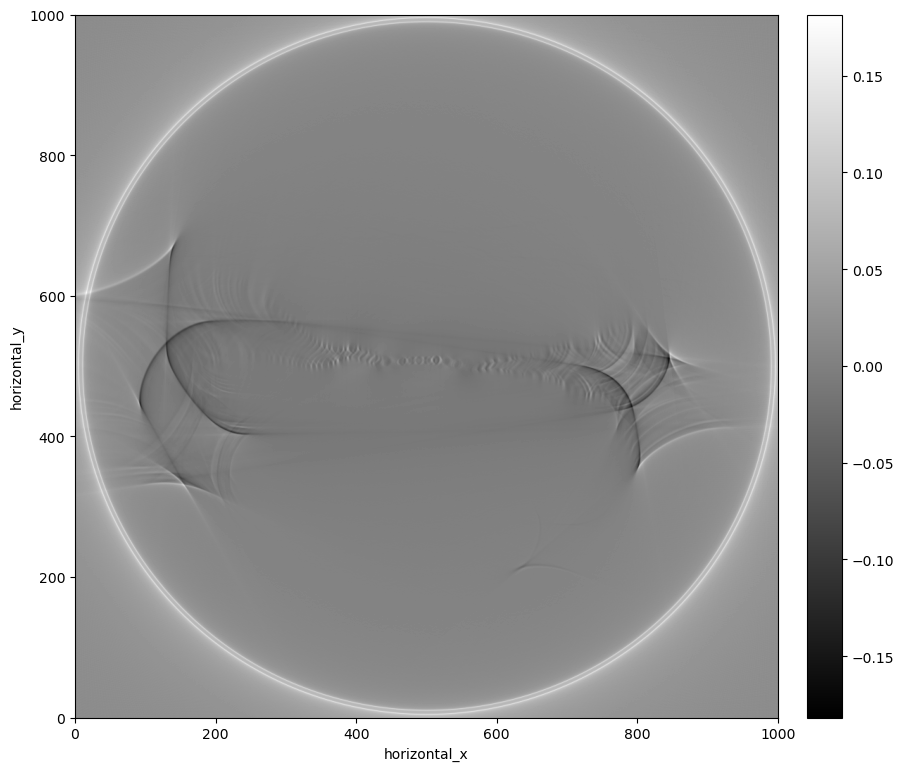

In [11]:
fdk = FDK(data_centre)
recon_centre = fdk.run()
show2D(recon_centre)

In [35]:
print(ag)

3D Cone-beam tomography
System configuration:
	Source position: [-2.70621576e-01, -2.55774841e+02, -5.70662244e-04]
	Rotation axis position: [2.03002814, 0.        , 0.00428074]
	Rotation axis direction: [0.54225055, 0.        , 0.84021684]
	Detector position: [-2.70621576e-01,  8.55973159e+02, -5.70662244e-04]
	Detector direction x: [0.99999778, 0.        , 0.0021087 ]
	Detector direction y: [-0.0021087 ,  0.        ,  0.99999778]
Panel configuration:
	Number of pixels: [1000 1000]
	Pixel size: [0.4 0.4]
	Pixel origin: top-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 1571
	Angles 0-20 in degrees:
[180.     , 179.77084, 179.54169, 179.31255, 179.08339, 178.85423,
 178.62508, 178.39592, 178.16678, 177.93762, 177.70847, 177.47931,
 177.25015, 177.02101, 176.79185, 176.5627 , 176.33354, 176.10439,
 175.87524, 175.64609]
Distances in units: units distance


In [34]:
# ag.config.system.rotation_axis_on_detector().position
ag.config.system.set_centre_of_rotation(10,10)

In [41]:
data2 = TransmissionAbsorptionConverter()(data)
# data3 = CentreOfRotationCorrector.image_sharpness(backend='tigre',search_range=500)(data2)
processor = CentreOfRotationCorrector.image_sharpness()
processor.set_input(data2)
data3 = processor.get_output()

NotImplementedError: Not implemented for rotated system geometries

In [39]:
print(data3.geometry)

AttributeError: 'CofR_xcorrelation' object has no attribute 'geometry'

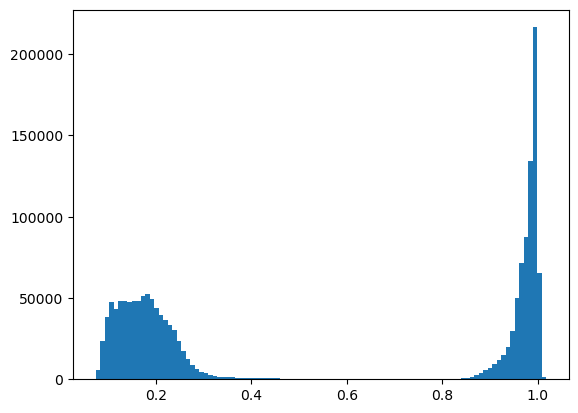

In [10]:
plt.hist(data_centre.as_array().flatten(),bins=100)
plt.show()

In [59]:
cor = data.geometry.get_centre_of_rotation(distance_units='pixels')
print(cor)
cor['offset']

{'offset': (2.940708160400385, 'pixels'), 'angle': (0.0021087062097677424, 'radian')}


(2.940708160400385, 'pixels')

In [7]:
ag_centre = data_centre.geometry
ig_centre = ag_centre.get_ImageGeometry()
print(ag_centre)
print(ig_centre)
# show_geometry(ag_centre,ig_centre, grid=True)

NameError: name 'data_centre' is not defined

In [60]:
ag_centre.set_centre_of_rotation(cor['offset'][0], distance_units=cor['offset'][1])

In [61]:
print(ag_centre)

2D Cone-beam tomography
System configuration:
	Source position: [   0.        , -255.77484131]
	Rotation axis position: [0.27062218, 0.        ]
	Detector position: [  0.        , 855.97315869]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [1000    1]
	Pixel size: [0.4 0.4]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 1571
	Angles 0-20 in degrees:
[180.     , 179.77084, 179.54169, 179.31255, 179.08339, 178.85423,
 178.62508, 178.39592, 178.16678, 177.93762, 177.70847, 177.47931,
 177.25015, 177.02101, 176.79185, 176.5627 , 176.33354, 176.10439,
 175.87524, 175.64609]
Distances in units: units distance


In [79]:
print(data_centre.min(), data_centre.max())

0.07393333 1.0181417


0.07393333 1.0181417
-0.017979147 2.6045916


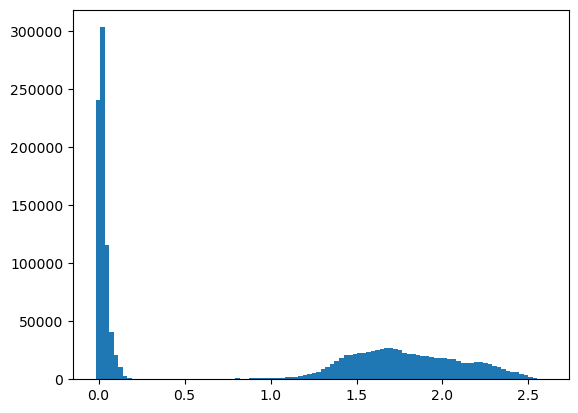

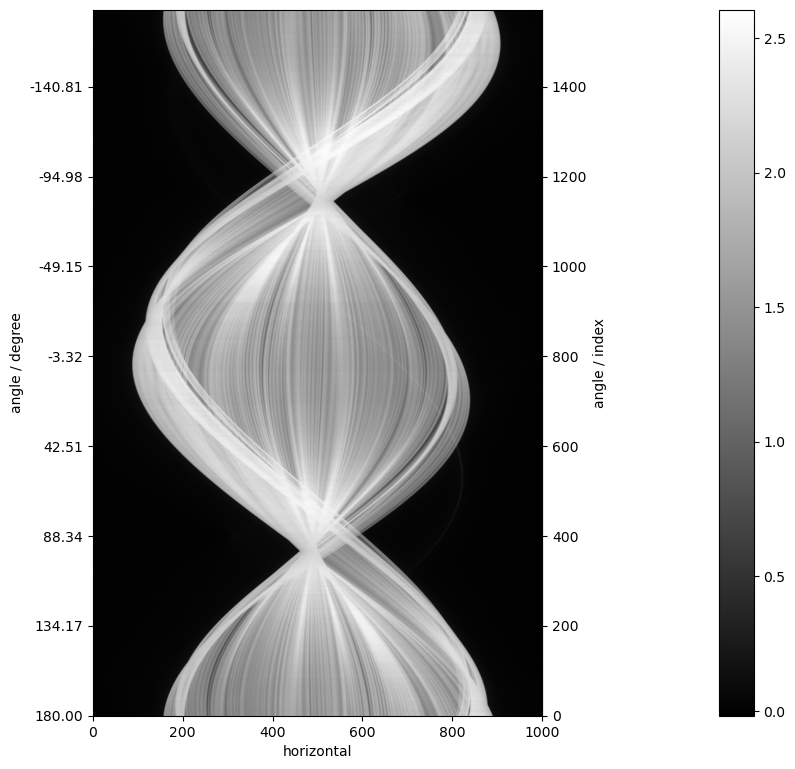

Number of dimensions: 2
Shape: (1571, 1000)
Axis labels: ('angle', 'horizontal')

FDK recon

Input Data:
	angle: 1571
	horizontal: 1000

Reconstruction Volume:
	horizontal_y: 1000
	horizontal_x: 1000

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False

FDK recon

Input Data:
	angle: 1571
	horizontal: 1000

Reconstruction Volume:
	horizontal_y: 1000
	horizontal_x: 1000

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



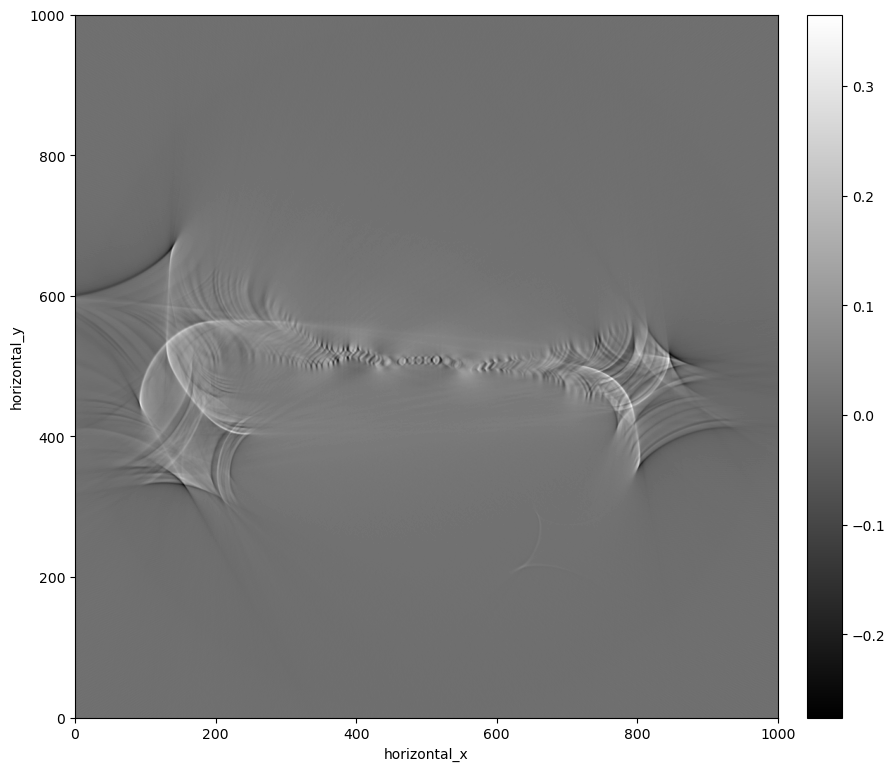

In [96]:
# data_centre /= data_centre.max()
print(data_centre.min(), data_centre.max())
data_centre = TransmissionAbsorptionConverter()(data_centre)
plt.hist(data_centre.as_array().flatten(),bins=100)
print(data_centre.min(), data_centre.max())
show2D(data_centre)
print(data_centre)

data_centre.reorder('tigre')
fdk = FDK(data_centre, ig_centre)
print(fdk)
recon_centre = fdk.run()
show2D(recon_centre)

In [91]:
data3 = CentreOfRotationCorrector.image_sharpness(backend='tigre',search_range=500)(data2)

ValueError: Unable to minimise function within set search_range

In [35]:
data_copy = copy.deepcopy(data)
ag_copy = data_copy.geometry
ig_copy = ag_copy.get_ImageGeometry()

In [36]:
print(ag_copy)

3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -255.77484131,    0.        ]
	Rotation axis position: [0.27062218, 0.        , 0.        ]
	Rotation axis direction: [0.0021087 , 0.        , 0.99999778]
	Detector position: [ -0.        , 855.97315869,   0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1000 1000]
	Pixel size: [0.4 0.4]
	Pixel origin: top-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 1571
	Angles 0-20 in degrees:
[180.     , 179.77084, 179.54169, 179.31255, 179.08339, 178.85423,
 178.62508, 178.39592, 178.16678, 177.93762, 177.70847, 177.47931,
 177.25015, 177.02101, 176.79185, 176.5627 , 176.33354, 176.10439,
 175.87524, 175.64609]
Distances in units: units distance


In [28]:
# print(ag_copy.config)
ag_copy.get_centre_of_rotation()

{'offset': (1.176283264160154, 'units distance'),
 'angle': (0.0021087062097677424, 'radian')}

In [31]:
ag_copy.set_centre_of_rotation(angle)

In [37]:
ag_copy.calculate_centre_of_rotation()

AttributeError: 'AcquisitionGeometry' object has no attribute 'calculate_centre_of_rotation'

In [33]:
print(data_copy.geometry)

3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -255.77484131,    0.        ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ -0.        , 855.97315869,   0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1000 1000]
	Pixel size: [0.4 0.4]
	Pixel origin: top-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 1571
	Angles 0-20 in degrees:
[180.     , 179.77084, 179.54169, 179.31255, 179.08339, 178.85423,
 178.62508, 178.39592, 178.16678, 177.93762, 177.70847, 177.47931,
 177.25015, 177.02101, 176.79185, 176.5627 , 176.33354, 176.10439,
 175.87524, 175.64609]
Distances in units: units distance


In [4]:
base_dir = os.path.abspath('/dtu/3d-imaging-center/projects/2022_DANFIX_Vindelev/raw_data_3DIM/')
# path = os.path.join(base_dir,'VKH8206-X20 [2022-02-08 10.27.26]/VKH8206-X20.xtekct')
path = os.path.join(base_dir,'VKH8206-X16 [2022-02-07 10.28.35]/VKH8206-X16.xtekct')
reader = NikonDataReader(file_name=path)
data2 = reader.read()

3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -114.42489624,    0.        ]
	Rotation axis position: [-0.,  0.,  0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ -0.        , 997.32310376,   0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [2000 2000]
	Pixel size: [0.2 0.2]
	Pixel origin: top-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 3142
	Angles 0-20 in degrees:
[-95.      , -95.11456 , -95.229126, -95.34369 , -95.45822 , -95.572784,
 -95.68735 , -95.80191 , -95.91647 , -96.03104 , -96.1456  , -96.26013 ,
 -96.374695, -96.48926 , -96.60382 , -96.71838 , -96.83295 , -96.94751 ,
 -97.06207 , -97.176605]
Distances in units: units distance
Number of channels: 1
channel_spacing: 1.0
voxel_num : x2000,y2000,z2000
voxel_size : x0.02058468218341459,y0.02058468218341459,z0.02058468218341459
center : x0,y0,z0



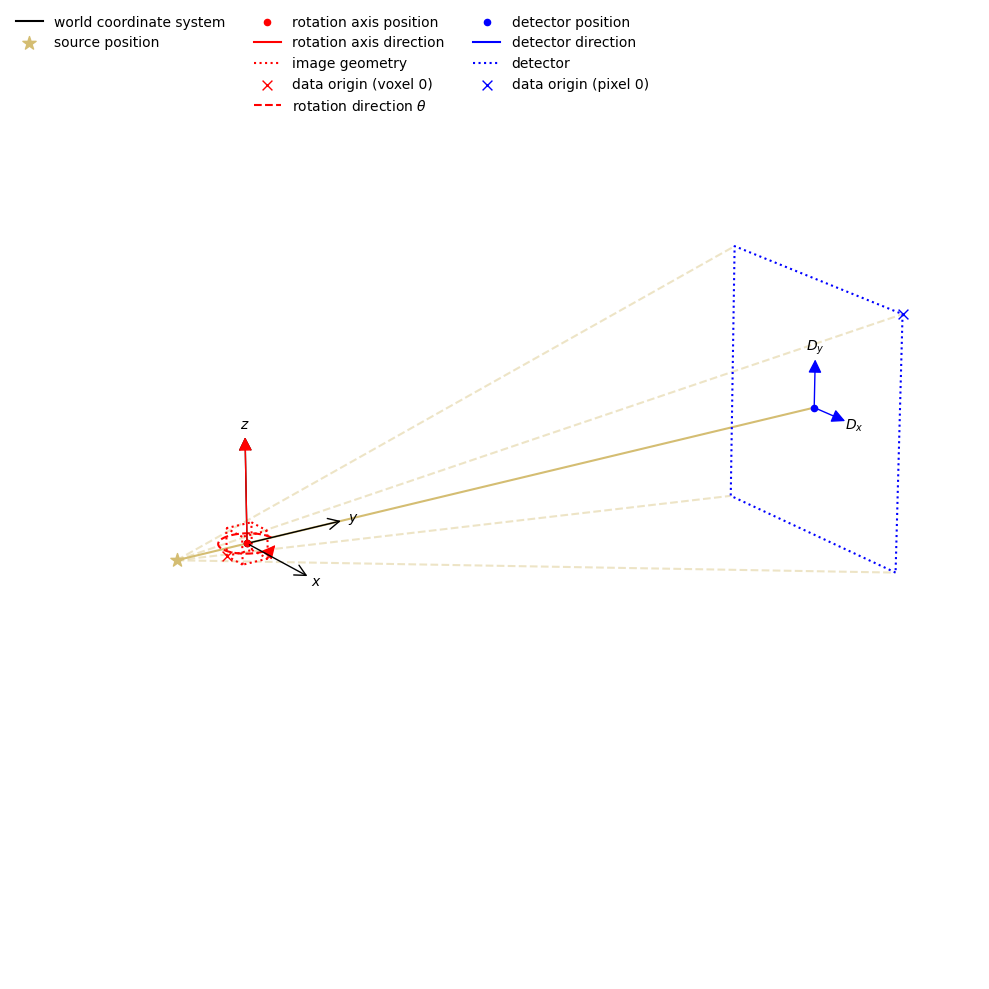

In [5]:
ag = data2.geometry
ig = ag.get_ImageGeometry()
print(ag)
print(ig)
show_geometry(ag, ig)

In [51]:
data_centre = data.get_slice(vertical='centre')

2D Cone-beam tomography
System configuration:
	Source position: [   0.        , -255.77484131]
	Rotation axis position: [0., 0.]
	Detector position: [  0.        , 855.97315869]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [1000    1]
	Pixel size: [0.4 0.4]
	Pixel origin: top-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 1571
	Angles 0-20 in degrees:
[180.     , 179.77084, 179.54169, 179.31255, 179.08339, 178.85423,
 178.62508, 178.39592, 178.16678, 177.93762, 177.70847, 177.47931,
 177.25015, 177.02101, 176.79185, 176.5627 , 176.33354, 176.10439,
 175.87524, 175.64609]
Distances in units: units distance
Number of channels: 1
channel_spacing: 1.0
voxel_num : x1000,y1000
voxel_size : x0.09202619345700429,y0.09202619345700429
center : x0,y0



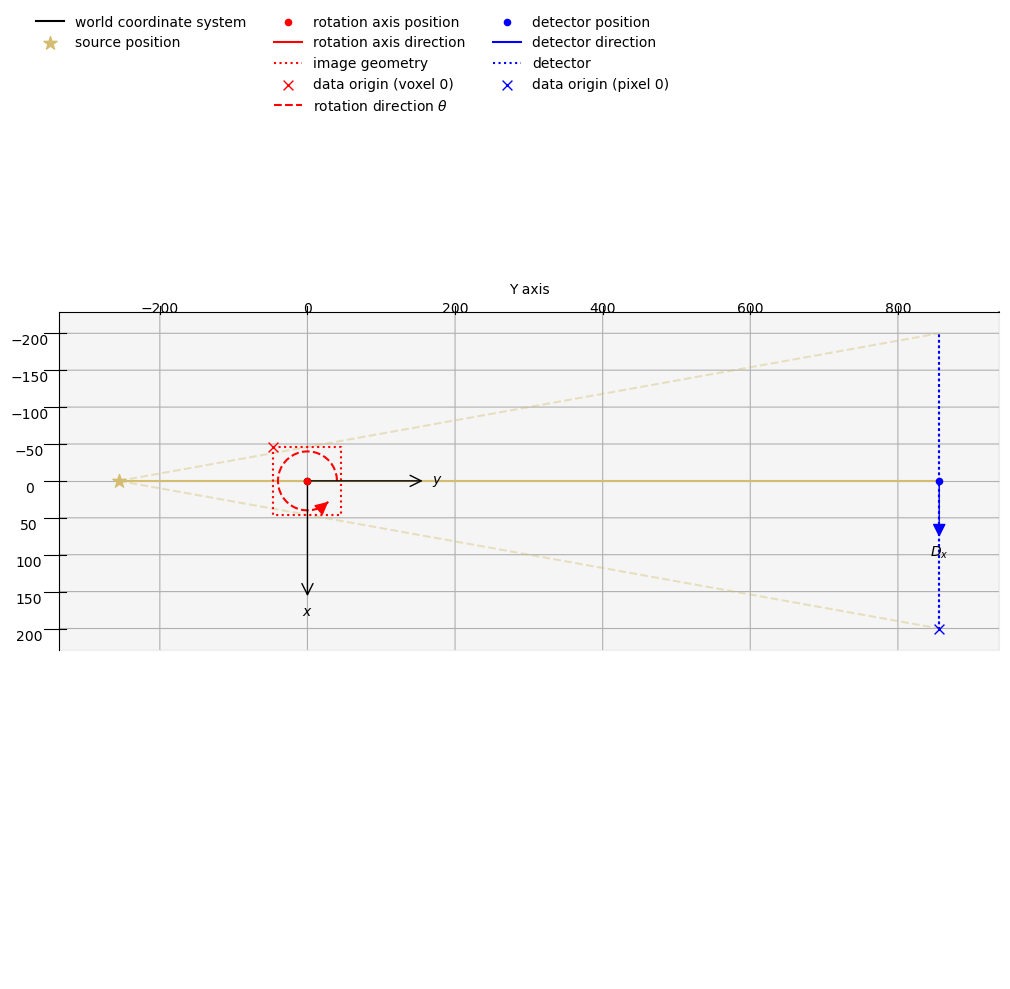

In [44]:
ag_centre = data_centre.geometry
ig_centre = ag_centre.get_ImageGeometry()
print(ag_centre)
print(ig_centre)
show_geometry(ag_centre,ig_centre, grid=True)

In [10]:
print(data_centre.min())
print(data_centre.max())
data_centre /= data_centre.max()
print(data_centre.min())
print(data_centre.max())

0.098825
1.01055
0.09779328
1.0


-0.026366051 2.0435598


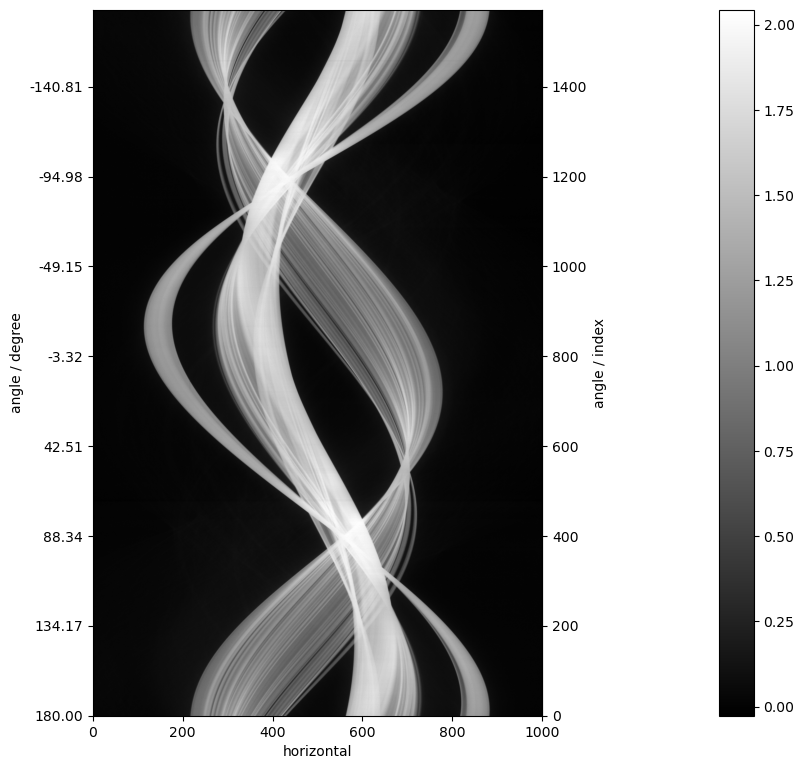

Number of dimensions: 2
Shape: (1571, 1000)
Axis labels: ('angle', 'horizontal')

FDK recon

Input Data:
	angle: 1571
	horizontal: 1000

Reconstruction Volume:
	horizontal_y: 1000
	horizontal_x: 1000

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



In [45]:
data_centre = TransmissionAbsorptionConverter()(data_centre)
print(data_centre.min(), data_centre.max())
show2D(data_centre)
print(data_centre)

data_centre.reorder('tigre')
fdk = FDK(data_centre, ig_centre)
print(fdk)

FDK recon

Input Data:
	angle: 1571
	horizontal: 1000

Reconstruction Volume:
	horizontal_y: 1000
	horizontal_x: 1000

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



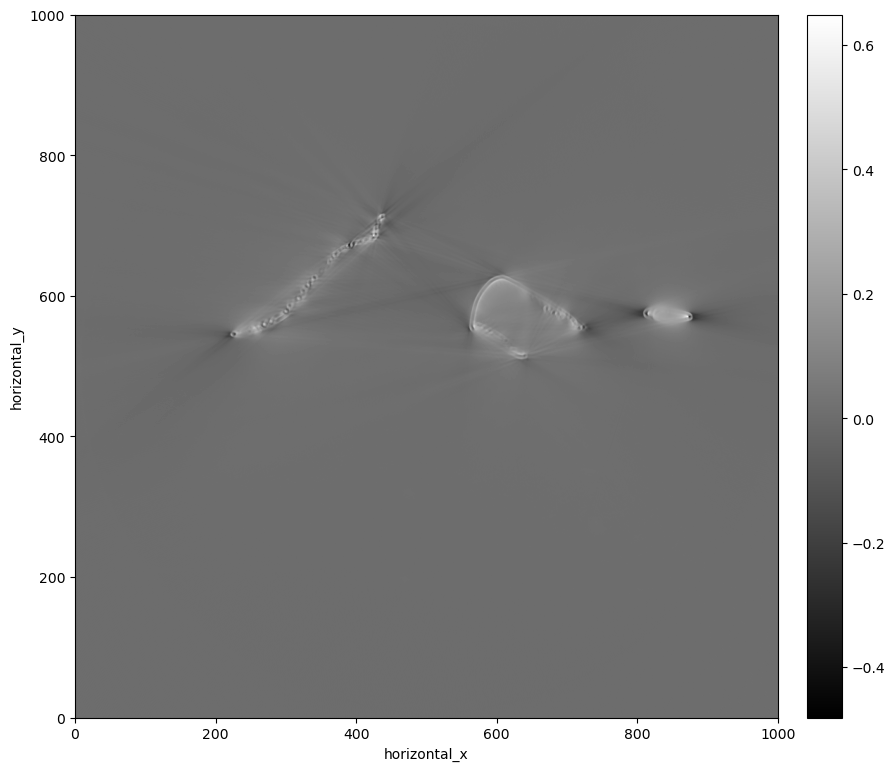

In [46]:
recon_centre = fdk.run()
show2D(recon_centre)

In [3]:
!nvidia-smi

Sun Feb 25 01:28:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           On  | 00000000:15:00.0 Off |                    0 |
| N/A   31C    P0              56W / 300W |    311MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [52]:

# base_dir = os.path.abspath('/dtu/3d-imaging-center/projects/2022_DANFIX_Vindelev/analysis/s214743_bsc/')
# file_path = os.path.join(base_dir,'centres/X12-X22.pkl')
# with open(file_path, 'wb') as file:
#     pickle.dump(data_centre, file)

In [15]:
print(ag)

3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -280.36486816,    0.        ]
	Rotation axis position: [-0.,  0.,  0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ -0.        , 831.38313184,   0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1000 1000]
	Pixel size: [0.4 0.4]
	Pixel origin: top-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 1571
	Angles 0-20 in degrees:
[180.     , 179.77084, 179.54169, 179.31255, 179.08339, 178.85423,
 178.62508, 178.39592, 178.16678, 177.93762, 177.70847, 177.47931,
 177.25015, 177.02101, 176.79185, 176.5627 , 176.33354, 176.10439,
 175.87524, 175.64609]
Distances in units: units distance


In [48]:
print(data.shape)
data.get_data_axes_order()

(1571, 1000, 1000)


('angle', 'vertical', 'horizontal')

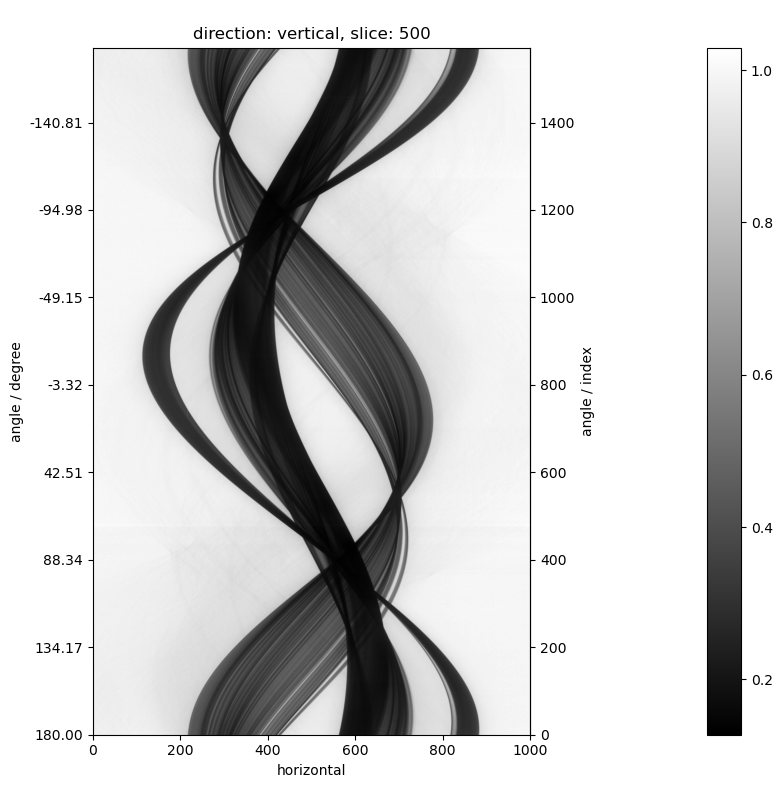

In [49]:
# show2D(data, slice_list=('horizontal',512))
# show2D(data)
show2D(data, slice_list=('vertical',500))

In [31]:
data = TransmissionAbsorptionConverter()(data)

In [39]:
fdk = FDK(data, ig)

In [40]:
!nvidia-smi

Sun Feb 25 02:53:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:37:00.0 Off |                    0 |
| N/A   54C    P0              40W / 250W |    425MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [41]:
recon = fdk.run()

FDK recon

Input Data:
	angle: 1571
	vertical: 1000
	horizontal: 1000

Reconstruction Volume:
	vertical: 1000
	horizontal_y: 1000
	horizontal_x: 1000

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



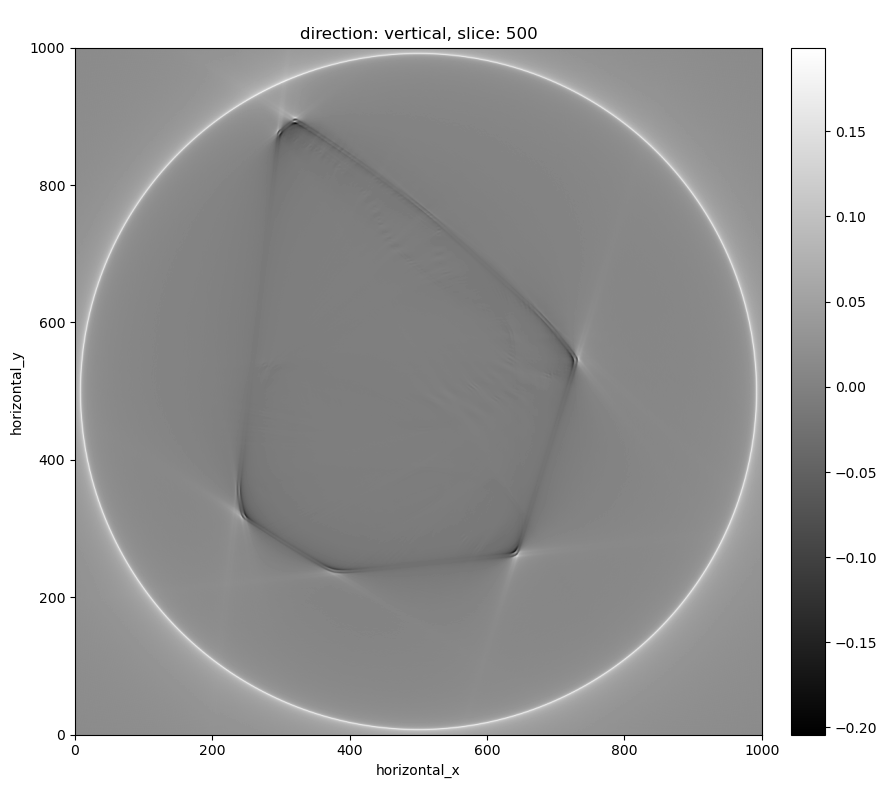

In [30]:
show2D(recon)

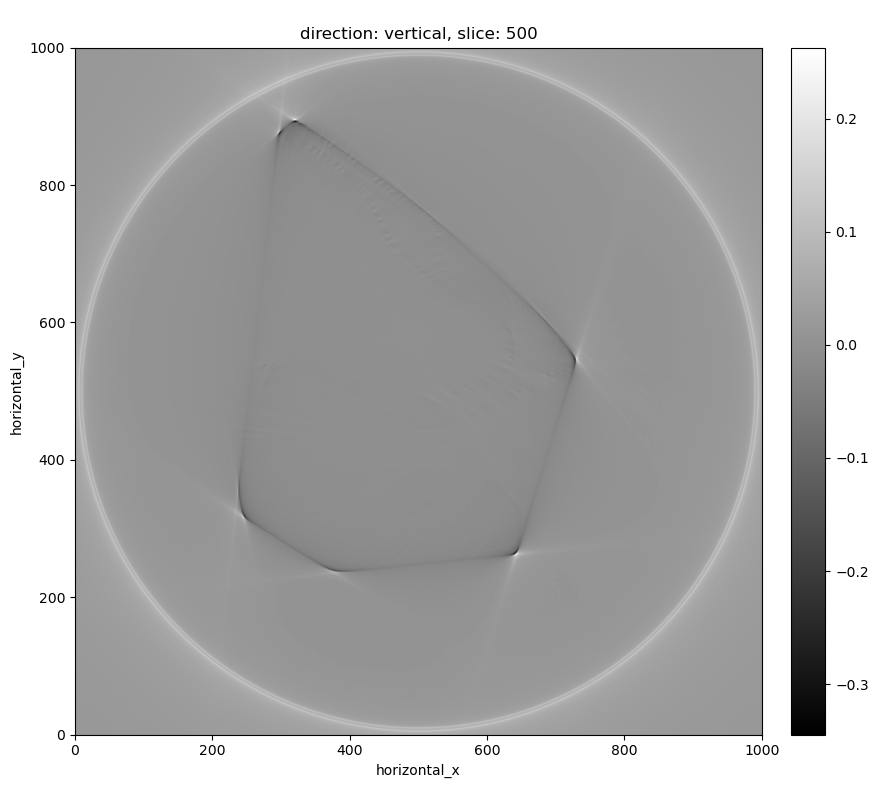

In [42]:
show2D(recon)

In [ ]:
data20 = Slicer(roi={'vertical':(490,510)})(data)

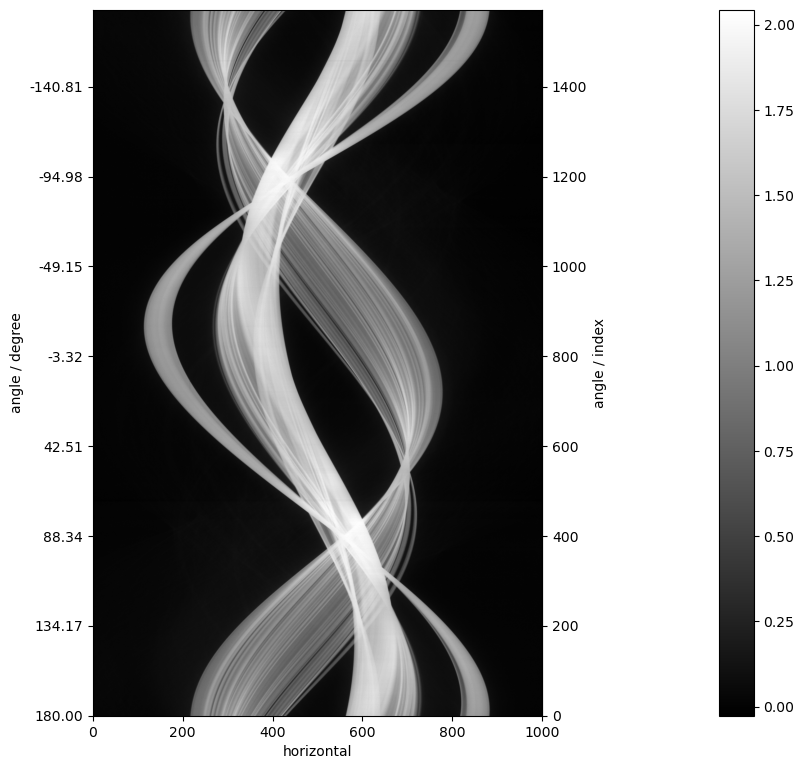

In [50]:
show2D(data_centre)

In [ ]:
data3 = CentreOfRotationCorrector.image_sharpness(backend='tigre',search_range=500)(data_centre)